### Предобработка данных

In [ ]:
import pandas as pd
df = pd.read_csv('RuFoLa фрагмент для практики.csv', encoding='utf-8')
# удаляем значения С2 -- их очень мало, они всё портят
df = df.drop(df[df['level_number'] == 6].index)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# делаем списки из нужных нам колонок
texts = df["text"].tolist()
labels = df["level"].tolist()

le = LabelEncoder()
labels = le.fit_transform(labels)

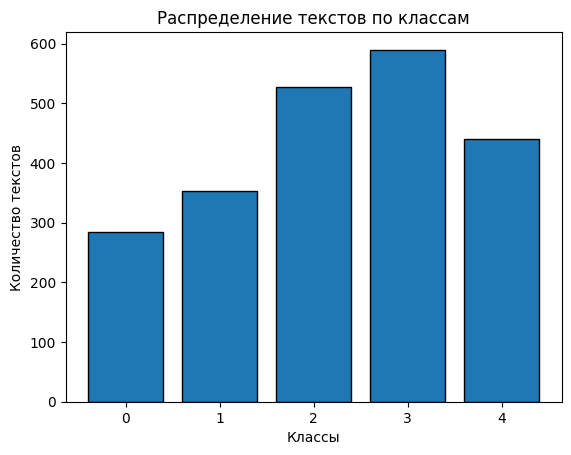

In [ ]:
# смотрим распределение данных по классам
import matplotlib.pyplot as plt

# Визуализация
plt.hist(labels, bins=np.arange(len(le.classes_)+1)-0.5, align='mid', rwidth=0.8, edgecolor='black')
plt.xlabel('Классы')
plt.ylabel('Количество текстов')
plt.title('Распределение текстов по классам')
plt.xticks(np.arange(len(le.classes_)))
plt.show()

In [ ]:
len(texts)

2196

In [ ]:
# разделеляем данные на обучающую и тестовую выборки
train_texts, vali_texts, train_labels, vali_labels = train_test_split(texts, labels, test_size=0.3, random_state=40)
val_texts, test_texts, val_labels, test_labels = train_test_split(vali_texts, vali_labels, test_size=0.5, random_state=40)
train_texts[:3]

['Доротея кончила свой рассказ, последние слова словно замерли у неё на губах. Вид у неё был измученный, взгляд потухший.Потрясённый, я судорожно перебирал бившиеся во мне слова, истинное значение которых я забыл. Я думал, что знаю о людях всё или почти всё – по собственному опыту или из книг. Но сейчас я понял, что книги, слова не выражают всей правды. У меня не укладывалось в сознании, как я мог жить до сих пор таким беззаботным, ничем не отягощённым, словно тело, лишённое тяжести. Она повернулась ко мне и устремила на меня пристальный взгляд. И хотя я не видел её во мраке и был весь поглощён своими мыслями, но ощутил на себе её взгляд. Встань, Антоний! – тихо произнесла она. – И не бойся.Я покорно встал. Дай мне руку!Я протянул ей руку. Её пальцы показались мне неожиданно тёплыми и сильными. А теперь, Антоний, взгляни на небо. Ты должен привыкнуть к нему.Привыкнуть к нему? Зачем человеку привыкать к небу? Скоро, Антоний, ты почувствуешь удивительную лёгкость. Словно ты стал вдруг во

### TRANSFORMERS


In [ ]:
# токенизация
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# model_name = "sberbank-ai/ruRoberta-large"
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

import torch
# Выбор модели и токенизатора (например, RuBERT)

# model = AutoModelForSequenceClassification.from_pretrained('roberta-large')
# tokenizer = AutoTokenizer.from_pretrained('roberta-large')

# Функция для подготовки данных
def tokenize_function(examples):
    return tokenizer(examples, truncation=True, padding="max_length", max_length=512)

val_encodings = tokenize_function(val_texts)
train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:

import torch
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
       self.encodings = encodings
       self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    # Создаём датасеты для PyTorch
train_dataset = TextClassificationDataset(train_encodings, train_labels)
val_dataset = TextClassificationDataset(val_encodings, val_labels)
test_dataset = TextClassificationDataset(test_encodings, test_labels)

In [ ]:
print(train_dataset[1])

{'input_ids': tensor([   101,    304,  13302,   4609, 107835,  18716,    128,   5318,  65210,
         63819,  68250,    166,    326,    901,  15826,  37939,   7079,    128,
          3856, 118436,  26251,  21866,    128,  24835,    851,  12926,  58109,
           132,  47305,  30286,  24762,   7486,  65232,   3474,  72797,    128,
           625,  73237,  55696,    852,    612,  43902,    132,  11908,  17062,
         27895,    128,    612,  23458,  45734,   2231,  16967,  12904,    128,
           851, 104650,    852,   7011,   7079,  65733,   9954,    905,  10960,
           132,  23881,   2739,   4725,  46780,    156, 102958,    128,    150,
          3422,    839,   7805,  49775,  14363,    128,  11032,    128,   5318,
           877,  27321,    876,    128,    877,  66827,  32431,  18383,    851,
         35676,  83370,  45057,    851,  22510,    132,    777,   6636,    877,
         35676,  36071,  43045,   2010,  45304,    132,    839,   7239,    898,
          2748,   5768,  1

### GPU
Точность на тестовой выборке 0.5895765472312704
F1-мера на тестовой выборке 0.5571348023827405

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Модель для классификации

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Функция вычисления метрик
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Получаем полный отчет по метрикам
    report = classification_report(labels, preds, output_dict=True)

    # Извлекаем метрики для каждого класса
    metrics = {label: {metric: values[metric] for metric in ['precision', 'recall', 'f1-score', 'support']}
               for label, values in report.items() if label.startswith('level_')}

    # Добавляем общие метрики
    metrics['accuracy'] = report['accuracy']
    metrics['macro avg'] = report['macro avg']
    metrics['weighted avg'] = report['weighted avg']

    # Сохранение результатов в файл
    with open("classification_report.txt", "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=4, ensure_ascii=False)

    return metrics

# Параметры обучения
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=200,
    weight_decay=0.01,
    # evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    gradient_accumulation_steps=4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Обучение модели
# trainer.train()

for epoch in range(int(training_args.num_train_epochs)):
    print(f"\n==== Эпоха {epoch + 1}/{int(training_args.num_train_epochs)} ====\n")
    trainer.train(resume_from_checkpoint=None)  # обучение одной эпохи
    eval_metrics = trainer.evaluate()
    print(f"Метрики на валидации после эпохи {epoch + 1}:", eval_metrics)

# Оценка модели на тесте
predictions = trainer.predict(test_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)



pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



==== Эпоха 1/5 ====



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: limonovaaa24 (limonovaaa24-michigan-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.602700
20,1.593500
30,1.557800
40,1.552800
50,1.557600
60,1.510400
70,1.451000
80,1.458300
90,1.373600
100,1.138100


Trainer is attempting to log a value of "{'precision': 0.6227692825000047, 'recall': 0.5914485941939358, 'f1-score': 0.6008345098659567, 'support': 329.0}" of type <class 'dict'> for key "eval/macro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6097048598192601, 'recall': 0.5957446808510638, 'f1-score': 0.5971334748216349, 'support': 329.0}" of type <class 'dict'> for key "eval/weighted avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Метрики на валидации после эпохи 1: {'eval_loss': 1.184112310409546, 'eval_accuracy': 0.5957446808510638, 'eval_macro avg': {'precision': 0.6227692825000047, 'recall': 0.5914485941939358, 'f1-score': 0.6008345098659567, 'support': 329.0}, 'eval_weighted avg': {'precision': 0.6097048598192601, 'recall': 0.5957446808510638, 'f1-score': 0.5971334748216349, 'support': 329.0}, 'eval_runtime': 9.9792, 'eval_samples_per_second': 32.969, 'eval_steps_per_second': 8.317, 'epoch': 5.0}

==== Эпоха 2/5 ====



Step,Training Loss
10,0.176900
20,0.187700
30,0.178200
40,0.111000
50,0.235100
60,0.168900
70,0.134900
80,0.196300
90,0.158800
100,0.212700


Trainer is attempting to log a value of "{'precision': 0.6418050707533871, 'recall': 0.5903295241680334, 'f1-score': 0.6020528151469856, 'support': 329.0}" of type <class 'dict'> for key "eval/macro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6278431146610948, 'recall': 0.6048632218844985, 'f1-score': 0.6034280832954121, 'support': 329.0}" of type <class 'dict'> for key "eval/weighted avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Метрики на валидации после эпохи 2: {'eval_loss': 1.9394360780715942, 'eval_accuracy': 0.6048632218844985, 'eval_macro avg': {'precision': 0.6418050707533871, 'recall': 0.5903295241680334, 'f1-score': 0.6020528151469856, 'support': 329.0}, 'eval_weighted avg': {'precision': 0.6278431146610948, 'recall': 0.6048632218844985, 'f1-score': 0.6034280832954121, 'support': 329.0}, 'eval_runtime': 9.9251, 'eval_samples_per_second': 33.148, 'eval_steps_per_second': 8.363, 'epoch': 5.0}

==== Эпоха 3/5 ====



Step,Training Loss
10,0.008500
20,0.010400
30,0.022100
40,0.006200
50,0.006600
60,0.009300
70,0.022300
80,0.077300
90,0.040900
100,0.174900


Trainer is attempting to log a value of "{'precision': 0.6587173579109062, 'recall': 0.609921092020471, 'f1-score': 0.6228605263416264, 'support': 329.0}" of type <class 'dict'> for key "eval/macro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6464726934013139, 'recall': 0.6231003039513677, 'f1-score': 0.6253180303715294, 'support': 329.0}" of type <class 'dict'> for key "eval/weighted avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Метрики на валидации после эпохи 3: {'eval_loss': 2.267277479171753, 'eval_accuracy': 0.6231003039513677, 'eval_macro avg': {'precision': 0.6587173579109062, 'recall': 0.609921092020471, 'f1-score': 0.6228605263416264, 'support': 329.0}, 'eval_weighted avg': {'precision': 0.6464726934013139, 'recall': 0.6231003039513677, 'f1-score': 0.6253180303715294, 'support': 329.0}, 'eval_runtime': 9.9556, 'eval_samples_per_second': 33.047, 'eval_steps_per_second': 8.337, 'epoch': 5.0}

==== Эпоха 4/5 ====



Step,Training Loss
10,0.002600
20,0.002600
30,0.002600
40,0.001500
50,0.002900
60,0.035300
70,0.001700
80,0.024700
90,0.035600
100,0.008400


Trainer is attempting to log a value of "{'precision': 0.6463391319382102, 'recall': 0.590350819642745, 'f1-score': 0.6031207925095753, 'support': 329.0}" of type <class 'dict'> for key "eval/macro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6325202956122654, 'recall': 0.6109422492401215, 'f1-score': 0.6071401253178594, 'support': 329.0}" of type <class 'dict'> for key "eval/weighted avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Метрики на валидации после эпохи 4: {'eval_loss': 2.896143674850464, 'eval_accuracy': 0.6109422492401215, 'eval_macro avg': {'precision': 0.6463391319382102, 'recall': 0.590350819642745, 'f1-score': 0.6031207925095753, 'support': 329.0}, 'eval_weighted avg': {'precision': 0.6325202956122654, 'recall': 0.6109422492401215, 'f1-score': 0.6071401253178594, 'support': 329.0}, 'eval_runtime': 10.0208, 'eval_samples_per_second': 32.832, 'eval_steps_per_second': 8.283, 'epoch': 5.0}

==== Эпоха 5/5 ====



Step,Training Loss
10,0.000700
20,0.000500
30,0.000400
40,0.000500
50,0.000700
60,0.000600
70,0.000500
80,0.000900
90,0.000500
100,0.008000


Trainer is attempting to log a value of "{'precision': 0.63558989467777, 'recall': 0.5709810975773708, 'f1-score': 0.5792905452035886, 'support': 329.0}" of type <class 'dict'> for key "eval/macro avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.618443258740989, 'recall': 0.5805471124620061, 'f1-score': 0.5789834305600131, 'support': 329.0}" of type <class 'dict'> for key "eval/weighted avg" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Метрики на валидации после эпохи 5: {'eval_loss': 3.3989098072052, 'eval_accuracy': 0.5805471124620061, 'eval_macro avg': {'precision': 0.63558989467777, 'recall': 0.5709810975773708, 'f1-score': 0.5792905452035886, 'support': 329.0}, 'eval_weighted avg': {'precision': 0.618443258740989, 'recall': 0.5805471124620061, 'f1-score': 0.5789834305600131, 'support': 329.0}, 'eval_runtime': 10.0128, 'eval_samples_per_second': 32.858, 'eval_steps_per_second': 8.289, 'epoch': 5.0}


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        40
           1       0.68      0.75      0.71        60
           2       0.54      0.67      0.60        86
           3       0.52      0.62      0.57        82
           4       0.78      0.29      0.42        62

    accuracy                           0.63       330
   macro avg       0.70      0.64      0.65       330
weighted avg       0.66      0.63      0.62       330


Confusion Matrix:
[[35  5  0  0  0]
 [ 0 45 15  0  0]
 [ 0 15 58 13  0]
 [ 0  1 25 51  5]
 [ 0  0 10 34 18]]


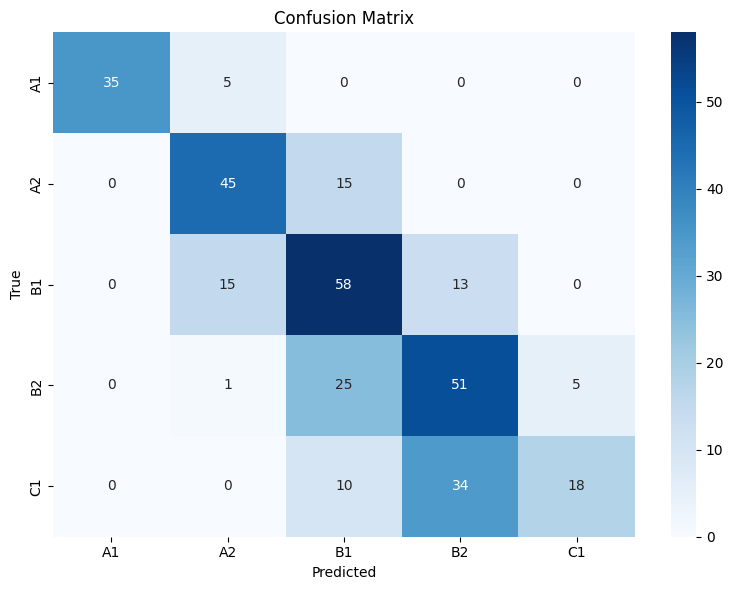

In [ ]:
predictions = trainer.predict(test_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)


# Вывод classification report
print("Classification Report:")
print(classification_report(labels, preds, digits=2))


# Вывод confusion matrix
cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix:")
print(cm)

# Отрисовка confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()